In [2]:
import os
from mpi4py import MPI
import pickle
pwd = '/pscratch/sd/s/sijingdu/VMC/fermion/data'

# torch
import torch
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb.tensor as qtn
import autoray as ar

from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_chain
from vmc_torch.torch_utils import SVD,QR

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
L = int(8)
symmetry = 'U1'
t = 1.0
U = 8.0
N_f = int(L)
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_chain(L, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 4
chi = -1
dtype=torch.float64

# Load mps
skeleton = pickle.load(open(pwd+f"/L={L}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/mps_skeleton.pkl", "rb"))
mps_params = pickle.load(open(pwd+f"/L={L}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/mps_su_params.pkl", "rb"))
mps0 = qtn.unpack(mps_params, skeleton)
mps0.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))
mps0.canonicalize_(where=0, cur_orthog=None)
mps0.normalize()

tensor(0.0037, dtype=torch.float64)

In [3]:
from autoray import do
import math
import symmray as sr
from symmray.fermionic_local_operators import FermionicOperator


def fix_phy_ind(mps0, site_config_dict, inplace=True, dtype=torch.float64):
    mps = mps0 if inplace else mps0.copy()
    if mps.symmetry == 'Z2':
        index_map = {0:0, 1:1, 2:1, 3:0}
        array_map = {
            0: do('array',[1.0, 0.0], like=mps.arrays[0].backend,dtype=dtype), 
            1: do('array',[1.0, 0.0], like=mps.arrays[0].backend,dtype=dtype), 
            2: do('array',[0.0, 1.0], like=mps.arrays[0].backend,dtype=dtype), 
            3: do('array',[0.0, 1.0], like=mps.arrays[0].backend,dtype=dtype)
        }
    elif mps.symmetry == 'U1':
        index_map = {0:0, 1:1, 2:1, 3:2}
        array_map = {
            0: do('array',[1.0,], like=mps.arrays[0].backend,dtype=dtype), 
            1: do('array',[1.0, 0.0], like=mps.arrays[0].backend,dtype=dtype), 
            2: do('array',[0.0, 1.0], like=mps.arrays[0].backend,dtype=dtype), 
            3: do('array',[1.0,], like=mps.arrays[0].backend,dtype=dtype)
        }

    for site, n_prob in site_config_dict.items():
        if type(n_prob) == tuple:
            n, prob = n_prob
        else:
            n, prob = n_prob, 1.0
        p_ind = mps.site_ind_id.format(site)
        site_id = mps.sites.index(site)
        fts = mps[site_id]
        ftsdata = fts.data
        ftsdata.phase_sync(inplace=True) # explicitly apply all lazy phases that are stored and not yet applied
        phys_ind_order = fts.inds.index(p_ind)
        charge = index_map[int(n)]
        input_vec = array_map[int(n)]
        charge_sec_data_dict = ftsdata.blocks
        new_fts_inds = fts.inds[:phys_ind_order] + fts.inds[phys_ind_order+1:]
        new_charge_sec_data_dict = {}
        for charge_blk, data in charge_sec_data_dict.items():
            if charge_blk[phys_ind_order] == charge:
                new_data = do('tensordot', data, input_vec, axes=([phys_ind_order], [0]))
                new_charge_blk = charge_blk[:phys_ind_order] + charge_blk[phys_ind_order+1:]
                new_charge_sec_data_dict[new_charge_blk]=new_data
                
        new_duals = ftsdata.duals[:phys_ind_order] + ftsdata.duals[phys_ind_order+1:]

        if int(n) == 1:
            new_oddpos = (3*site_id+1)*(-1)
        elif int(n) == 2:
            new_oddpos = (3*site_id+2)*(-1)
        elif int(n) == 3 or int(n) == 0:
            new_oddpos = ()

        new_oddpos1 = FermionicOperator(new_oddpos, dual=True) if new_oddpos != () else ()
        new_oddpos = ftsdata.oddpos + (new_oddpos1,) if new_oddpos1 is not () else ftsdata.oddpos
        oddpos = list(new_oddpos)[::-1]
        
        new_fts_data = sr.FermionicArray.from_blocks(new_charge_sec_data_dict, duals=new_duals, charge=charge+ftsdata.charge, oddpos=oddpos, symmetry=ftsdata.symmetry)
        fts.modify(data=new_fts_data/(prob**0.5), inds=new_fts_inds, left_inds=None)
        # mps.contract_ind(fts.inds)
        mps.draw()
    
    return mps

def get_marginal_prob(mps0, site, inplace=False):
    mps = mps0 if inplace else mps0.copy()
    mpsH = mps.H
    mpsH_site = mpsH.reindex({
        mps.site_ind_id.format(site): r'b{}'.format(site),
    })
    prob_density = (mpsH_site|mps).contract()

    # probs = (prob_density.data.to_dense()).diag()
    probs = torch.zeros(4, dtype=dtype)
    # print(prob_density.data.blocks, (prob_density.data.to_dense()).diag())
    for charge_blk, data in prob_density.data.blocks.items():
        if charge_blk == (0,0):
            probs[0] = data.diag().sum()
        elif charge_blk == (1,1):
            probs[1] = data.diag()[0]
            probs[2] = data.diag()[1]
        elif charge_blk == (2,2):
            probs[3] = data.diag().sum()
    # assert float(sum(probs)) is very close to 1.0
    if math.isclose(abs(float(sum(probs))), 1.0, rel_tol=1e-5) == False:
        # print(f"Probability density does not sum to 1.0, but {abs(float(sum(probs)))}")
        raise ValueError(f"Probability density does not sum to 1.0, but {abs(float(sum(probs)))}")
    return abs(probs)

# define a function to draw sample from the discrete probability like tensor([0.0237, 0.2950, 0.6575, 0.0238], dtype=torch.float64)
def sample_s(prob_density, indices=None):
    if indices is None:
        indices = torch.arange(prob_density.shape[0])
    sample = indices[torch.multinomial(prob_density, 1, replacement=True)][0]
    prob = prob_density[sample]
    return sample, prob

# sample from the probability density
mps = mps0.copy()
mps.normalize()
site = 7
probs = get_marginal_prob(mps, site)

config7, prob7 = sample_s(probs)
site_config_dict = {
    site: (config7, prob7)
}

<>:58: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:58: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_262319/1028511202.py:58: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  new_oddpos = ftsdata.oddpos + (new_oddpos1,) if new_oddpos1 is not () else ftsdata.oddpos


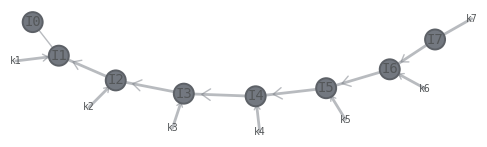

Site 0 Prob sum: 0.9999999999999999, config: 1, prob: 0.7287747842574067


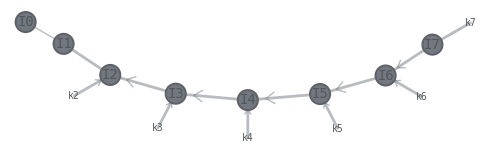

Site 1 Prob sum: 1.0000000000000002, config: 2, prob: 0.8859590139689891


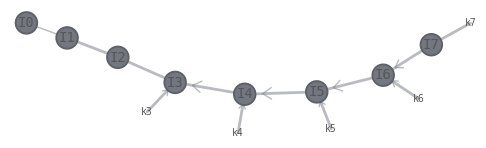

Site 2 Prob sum: 0.9999999999999999, config: 1, prob: 0.8367883917141906


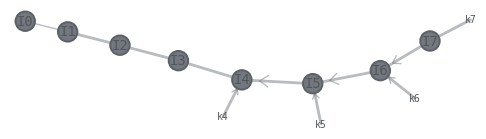

Site 3 Prob sum: 0.9999999999999999, config: 2, prob: 0.8745135524525521


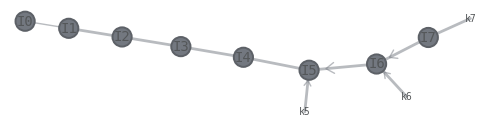

Site 4 Prob sum: 1.0000000000000004, config: 1, prob: 0.8326624921129049


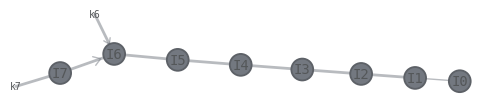

Site 5 Prob sum: 0.9999999999999993, config: 2, prob: 0.9009346017272807


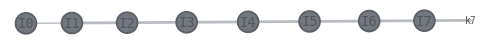

Site 6 Prob sum: 1.0000000000000002, config: 1, prob: 0.705861545563993


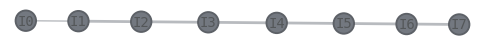

Site 7 Prob sum: 1.0, config: 2, prob: 0.9991928206674969
tensor([1, 2, 1, 2, 1, 2, 1, 2])


tensor(0.5000, dtype=torch.float64)

In [4]:
def direct_sample(mps0, inplace=False):
    mps = mps0 if inplace else mps0.copy()
    mps.normalize()
    total_prob = 1.0
    site_config_dict = {}
    configs = []
    for site in range(mps.L):
        probs = get_marginal_prob(mps, site, inplace=True)
        config, prob = sample_s(probs)
        total_prob *= prob
        site_config_dict[site] = (config, prob)
        configs.append(config)
        current_site_config = {site: (config, prob)}
        mps_copy = mps.copy()
        mps = fix_phy_ind(mps, current_site_config, inplace=True)
        print(f"Site {site} Prob sum: {abs(float(sum(probs)))}, config: {config}, prob: {prob}")
    return torch.tensor(configs), mps_copy

configs, mpsc = direct_sample(mps)
print(configs)
mps.get_amp(configs).contract()

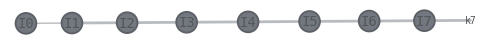

In [483]:
mpsc.draw()

In [482]:
mpsc.contract().data.blocks

{(1,): tensor([-0.9981,  0.0622], dtype=torch.float64)}

In [165]:
mps1 = fix_phy_ind(mps.copy(), site_config_dict, inplace=False, dtype=dtype)
mps1.H

site 7 n: 2 prob 0.6575436581996749


fMPS(tensors=8, indices=14, L=8, max_bond=4)

In [26]:
probs = get_marginal_prob(mps1, 6, inplace=False)

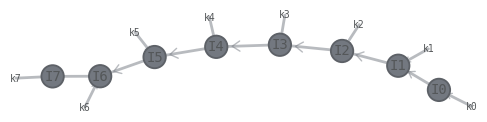

In [6]:
mps1 = qtn.MPS_rand_state(L, D, phys_dim=4)
mps1.canonicalize_(where=L-1, cur_orthog=None).draw()